# ALC Simulations based on Analytical Solutions

### $\Delta_1$ resonance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.constants import pi
import seaborn as sns
from plot_settings import set_demonlab_style

def muon_polarization_time_integrated(magnetic_fields, theta, Pz_0, off_resonance_state_rate, A_iso, D_parallel):
    """
    Calculate the time-integrated muon polarization for a given magnetic field and angle theta.
    """
    gamma_muon = 135.5 # in MHz/T
    inv_muon_lifetime = 0.4551 # in MHz
    osc_relaxation = inv_muon_lifetime + off_resonance_state_rate # in MHz

    def calc_q(theta, D_parallel):
        return 0.75 * D_parallel * np.sin(theta) * np.cos(theta)

    def calc_nu_mu(A_iso, D_parallel, theta):
        return (A_iso + D_parallel/2 * (3 * np.cos(theta)**2 - 1)) / 2

    q = calc_q(theta, D_parallel)
    nu_mu = calc_nu_mu(A_iso, D_parallel, theta)
    nu_mu0 = gamma_muon * magnetic_fields

    nominator = 0.5 * q**2 * Pz_0
    denominators = (osc_relaxation/2/pi)**2 + q**2 + (nu_mu0 - nu_mu)**2

    return 1 - nominator/denominators

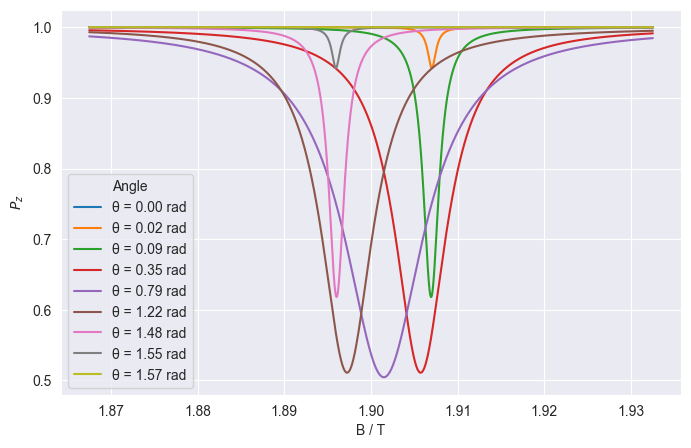

In [3]:
magnetic_fields = np.linspace(1.8675, 1.9325, 3000) # in Tesla
thetas = np.radians([0, 1, 5, 20, 45, 70, 85, 89, 90]) # given in degrees and converted to radians
Pz_0 = 1.0
off_resonance_state_rate = 0
A_iso = 514.8 # in MHz
D_parallel = 2 # in MHz

# Parameters for SrTiO3
# magnetic_fields = np.linspace(0, 0.78, 3000) # in Tesla
# thetas = np.radians([1, 5, 20, 45, 70, 85, 89]) # given in degrees and converted to radians
# Pz_0 = 1.0
# off_resonance_state_rate = 0
# A_iso = 1 # in MHz
# D_parallel = 30 # in MHz

df = pd.DataFrame({'B / T': magnetic_fields})
for theta in thetas:
    df[f"θ = {theta:.2f} rad"] = muon_polarization_time_integrated(magnetic_fields, theta, Pz_0, off_resonance_state_rate, A_iso, D_parallel)

polarizations = muon_polarization_time_integrated(magnetic_fields, theta, Pz_0, off_resonance_state_rate, A_iso, D_parallel)

# Melt for seaborn plotting
df_melted = df.melt(id_vars="B / T", var_name="θ", value_name="Pz")

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(data=df_melted, x="B / T", y="Pz", hue="θ")
plt.xlabel("B / T")
plt.ylabel(r"$P_z$")
plt.legend(title="Angle")
